## Setting Up:

In [1]:
from matplotlib import pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import re
from pathlib import Path
import xarray as xr
import warnings
import re
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV as RSCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, MaxNLocator

warnings.filterwarnings("ignore")

In [2]:
from scripts.xgb_helpers import *
from scripts.stakes_processing import *
from scripts.xgb_input import *
from scripts.xgb_model import *
from scripts.xgb_model_varcomb import *
from scripts.plots_clean import *
from scripts.xgb_metrics import *
from scripts.xgb_extreme import *
from scripts.PDD_model_modules import *
from scripts.PDD_model_calibration import *
from scripts.PDD_helpers import *

%load_ext autoreload
%autoreload 2

In [3]:
# set seed everywhere:
seed_all(SEED)

# Parameter grid of XGBoost training Hyperparameters
param_grid = {
    'learning_rate': np.arange(0.01, 0.2, 0.01),
    'n_estimators': np.arange(50, 300, 15),
    'max_depth': np.arange(3, 10, 1),
}
INPUT_TYPE = "ERA5-Land"
# SUFFIX = "full"  # take metrics over whole time series instead of folds

KFOLD = True
if KFOLD:
    NUM_FOLDS = 5
    FOLD = 'kfold'
else:
    NUM_FOLDS = 1
    FOLD = 'single_fold'

path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

In [4]:
# Colors:

# For bars and lines:
color_diff_xgb = '#878787'
color_diff_xgbplus = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 2)
color_xgbplus = colors[0]
color_tim = colors[1]
color_xgb = '#4575b4'

# Violin and boxplots:
colors_temp_freq = sns.color_palette(get_cmap_hex(cm.devon, 8))
boxplot_style = {
    "width": .2,
    "showcaps": False,
    "palette": colors_temp_freq,
    "flierprops": {
        "marker": "x"
    },
}

marker_tim = 's'
marker_xgb = 'o'

In [6]:
# Get number of stakes per glacier and their names
glStakesNum, glStakes = get_StakesNum(path_GLAMOS_csv)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])

# Get total number of stakes
num_stakes = 0
for (glacier, num) in (glStakes_sorted):
    num_stakes += num
print('Total number of stakes:', num_stakes)
print('Number of stakes per glacier:\n', glStakes_sorted)

# glacier names:
glaciers = list(glStakes.keys())

# Select same stakes as for MS experiment
glStakes_20years = {
    'basodino':
    ['basodino_P5_mb.csv', 'basodino_P8_mb.csv', 'basodino_P10_mb.csv'],
    'gries': ['gries_P32_mb.csv', 'gries_P112_mb.csv'],
    'schwarzberg': ['schwarzberg_P2_mb.csv'],
    'aletsch': [
        'aletsch_P5_mb.csv', 'aletsch_P0_mb.csv', 'aletsch_P9_mb.csv',
        'aletsch_P10_mb.csv', 'aletsch_P3_mb.csv'
    ],
    'limmern': ['limmern_P2_mb.csv', 'limmern_P1_mb.csv', 'limmern_P3_mb.csv'],
    'clariden': ['clariden_U_mb.csv', 'clariden_L_mb.csv'],
    'allalin': ['allalin_P1_mb.csv'],
    'silvretta':
    ['silvretta_P9_mb.csv', 'silvretta_BO_mb.csv', 'silvretta_BU_mb.csv'],
    'hohlaub': ['hohlaub_P2_mb.csv'],
    'pers': ['pers_P24_mb.csv'],
    'corbassiere': ['corbassiere_B2_mb.csv'],
    'plattalva': ['plattalva_P10_mb.csv', 'plattalva_P11_mb.csv'],
    'gietro': ['gietro_P1_mb.csv', 'gietro_P3_mb.csv', 'gietro_P5_mb.csv']
}

print('After preprocessing:\n----\nNumber of glaciers:',
      len(glStakes_20years.keys()))
num_stakes = 0
for gl in glStakes_20years.keys():
    num_stakes += len(glStakes_20years[gl])
print('Number of stakes:', num_stakes)

# Rename stakes for plots:
names_stakes = rename_stakes(glStakes_20years)

glStakes_20years_all = np.concatenate(list(glStakes_20years.values()))
glStakes_20years_all = [x[:-7] for x in glStakes_20years_all]

Total number of stakes: 46
Number of stakes per glacier:
 [('sanktanna', 1), ('adler', 1), ('schwarzberg', 1), ('plainemorte', 1), ('allalin', 1), ('hohlaub', 1), ('corbassiere', 1), ('tsanfleuron', 2), ('gries', 2), ('pizol', 2), ('clariden', 2), ('pers', 2), ('murtel', 2), ('plattalva', 2), ('basodino', 3), ('rhone', 3), ('limmern', 3), ('silvretta', 3), ('gietro', 3), ('findelen', 4), ('aletsch', 6)]
After preprocessing:
----
Number of glaciers: 13
Number of stakes: 28


### Compare MS and ERA5-Land:

Text(0.5, 0.98, 'gietro_P1')

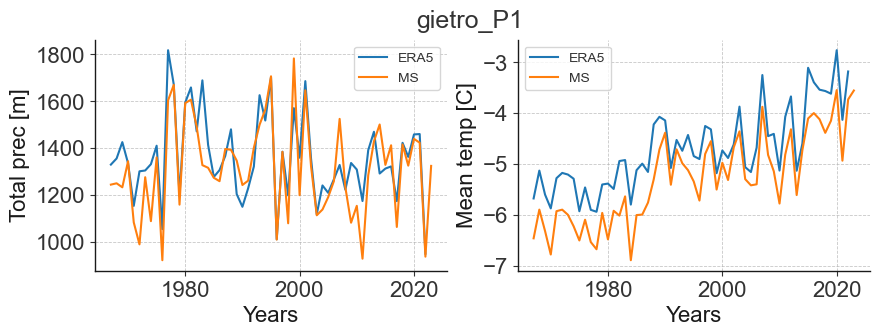

In [7]:
# Example of climate data from MeteoSuisse
stake = glStakes_20years[gl][0]
stakeName = re.split(".csv", stake)[0][:-3]
df_stake = read_stake_csv(path_glacattr, stake, COI)

# ERA5
fileName = re.split(".csv", stake)[0]
xr_temppr = xr.open_dataset(path_era5_stakes +
                            f"{fileName}_full.nc").sortby("time")
begin_xr = pd.to_datetime(xr_temppr["time"].values[0]).year
end_xr = pd.to_datetime(xr_temppr["time"].values[-1]).year
df_stake_cut = cutStake(df_stake, begin_xr, end_xr)
target_DF = df_stake_cut[df_stake_cut.vaw_id > 0]

# MS
xr_temp_MS = xr.open_dataset(path_MS + f"{fileName}_full.nc").sortby("time")
begin_xr_MS = pd.to_datetime(xr_temp_MS["time"].values[0]).year
end_xr_MS = pd.to_datetime(xr_temp_MS["time"].values[-1]).year
df_stake_cut_MS = cutStake(df_stake, begin_xr_MS, end_xr_MS)
target_DF_MS = df_stake_cut_MS[df_stake_cut_MS.vaw_id > 0]

df_yearly = createInputDF_year(df_stake_cut, xr_temppr).reset_index()
df_yearly['avg_temperature'] = df_yearly['avg_temperature']

df_yearly_MS = createInputDF_year(df_stake_cut_MS, xr_temp_MS).reset_index()
df_yearly_MS['avg_temperature'] = df_yearly_MS['avg_temperature']

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 2, 1)
sns.lineplot(df_yearly, x='index', y='tot_precipitation', label='ERA5', ax=ax)
sns.lineplot(df_yearly_MS, x='index', y='tot_precipitation', label='MS', ax=ax)
ax.set_xlabel('Years')
ax.set_ylabel('Total prec [m]')

ax = plt.subplot(1, 2, 2)
sns.lineplot(df_yearly, x='index', y='avg_temperature', label='ERA5', ax=ax)
sns.lineplot(df_yearly_MS, x='index', y='avg_temperature', label='MS', ax=ax)

ax.set_xlabel('Years')
ax.set_ylabel('Mean temp [C]')

plt.suptitle(stakeName)

## Load PDD:

In [8]:
# Match only annual MB in PDD:
var_pdd_a, metrics_pdd_a = assemblePDDStakes(
    path_pickles + f'{FOLD}/ERA5-Land/match_annual_winter/',
    glStakes_20years_all, names_stakes)
df_metrics_pdd = getDfMetrics(
    var_pdd_a, metrics_pdd_a, NUM_FOLDS,
    type_pred='annual_pred_PDD').sort_values(by='stakes_full')

# Match only annual MB in PDD:
var_pdd_a_MS, metrics_pdd_a_MS = assemblePDDStakes(
    path_pickles + f'{FOLD}/MeteoSuisse/match_annual_winter/',
    glStakes_20years_all, names_stakes)
df_metrics_pdd_MS = getDfMetrics(
    var_pdd_a_MS, metrics_pdd_a_MS, NUM_FOLDS,
    type_pred='annual_pred_PDD').sort_values(by='stakes_full')

Reading files from: ../../../data/MB_modeling/PDD/kfold/ERA5-Land/match_annual_winter/
Reading files from: ../../../data/MB_modeling/PDD/kfold/MeteoSuisse/match_annual_winter/


## Run XGB:

### Annual:

In [9]:
# RUN = True
# if RUN:
#     runXGBoost(glStakes_20years,
#                param_grid,
#                temporalFreq='annual',
#                mb_match='annual',
#                kfold=KFOLD,
#                input_type=INPUT_TYPE)

# var_xg_annual, metrics_annual = assembleXGStakes(
#     path_save_xgboost_stakes +
#     f'{FOLD}/{INPUT_TYPE}/annual/t2m_tp/match_annual/',glStakes_20years_all)

### Monthly

In [10]:
# RUN = False
# if RUN:
#     runXGBoost(glStakes_20years,
#                param_grid,
#                temporalFreq='monthly',
#                kfold=KFOLD,
#                mb_match='annual',
#                input_type=INPUT_TYPE)

# var_xg_monthly, metrics_monthly = assembleXGStakes(
#     path_save_xgboost_stakes +
#     f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_annual/', glStakes_20years_all,
#     names_stakes,
#     rename = False)

### Optimized seasonal:

In [11]:
# Get hyper parameters for training all combinations
var_xg_monthly, metrics_monthly = assembleXGStakes(
    path_save_xgboost_stakes +
    f'{FOLD}/{INPUT_TYPE}/monthly/t2m_tp/match_annual/',
    glStakes_20years_all,
    names_stakes,
    rename=True)
hp_lr = metrics_monthly['hp_lr']
hp_ne = metrics_monthly['hp_ne']
hp_md = metrics_monthly['hp_md']

# Match annual MB:
df_metrics_monthly = getDfMetrics(var_xg_monthly,
                                  metrics_monthly,
                                  NUM_FOLDS,
                                  type_pred="pred_XG")

In [12]:
best_combi = [(['t2m_May', 't2m_June', 't2m_July', 't2m_Aug'], [
    'tp_Oct',
    'tp_Nov',
    'tp_Dec',
    'tp_Jan',
    'tp_Feb',
])]
best_months_t2m = [re.split('_', combi)[1] for combi in best_combi[0][0]]
best_months_tp = [re.split('_', combi)[1] for combi in best_combi[0][1]]

weights_t2m = np.ones(len(best_months_t2m))
weights_tp = np.ones(len(best_months_tp))

# Run XGBoost with best combinations of t2m variables
RUN = False
if RUN:
    runXGBoost_one_varcomb(
        best_combi,
        hp_lr,
        hp_ne,
        hp_md,
        glStakes_20years,
        param_grid,  # grid for HP search
        weights_t2m,
        weights_tp,
        mb_match='annual',
        input_type=INPUT_TYPE,
        log=False,
        empty_folder=True,
        grid_search=False,
        input_vars={
            "t2m": "temperature",
            "tp": "precipitation"
        })

In [13]:
VARS = ['t2m', 'tp']

var_xg_best_era5, metrics_best_era5 = assembleXGStakes(
    path_save_xgboost_stakes + f'{FOLD}/ERA5-Land/' +
    f'best_combi/grid_search_False/{VARS[0]}_{VARS[1]}/', glStakes_20years_all,
    names_stakes)

df_metrics_best_era5 = getDfMetrics(var_xg_best_era5,
                               metrics_best_era5,
                               NUM_FOLDS,
                               type_pred="pred_XG")

# MS
# var_xg_best_MS, metrics_best_MS = assembleXGStakes(
#     path_save_xgboost_stakes + f'{FOLD}/MeteoSuisse/' +
#     f'best_combi/grid_search_False/t2m_tp/', glStakes_20years_all,
#     names_stakes)

# df_metrics_best_MS = getDfMetrics(var_xg_best_MS,
#                                metrics_best_MS,
#                                NUM_FOLDS,
#                                type_pred="pred_XG")

var_xg_best_MS, metrics_best_MS = assembleXGStakes(
    path_save_xgboost_stakes + f'{FOLD}/MeteoSuisse/'  + f'best_combi/grid_search_False/t2m_tp/',
    glStakes_20years_all, names_stakes)

df_metrics_best_MS = getDfMetrics(var_xg_best_MS, metrics_best_MS,
                               NUM_FOLDS,
                               type_pred="pred_XG")


## Plots:

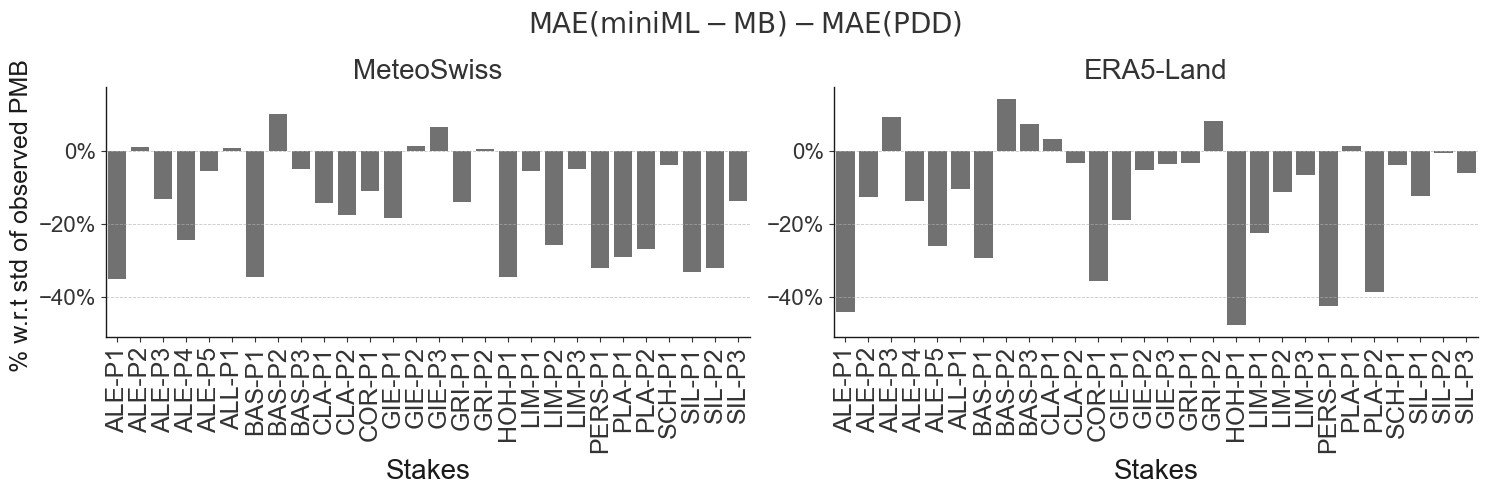

In [14]:
fig = plt.figure(figsize=(15, 5))
M, N = 1, 2

# Diff MAE:
ax1 = plt.subplot(
    M,
    N,
    1,
)
df_diff_best = calcDiff(df_metrics_best_MS, df_metrics_pdd_MS)
g = sns.barplot(
    df_diff_best,
    x='stakes_full',
    # y=f'diff_mae_xgb_full',
    y = 'diff_mae_wrt_to_std',
    # hue='glaciers',
    ax=ax1,
    dodge=False,
    alpha=0.8,
    color=color_diff_xgbplus,
    # palette=color_palette_glaciers
)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
h, l = g.get_legend_handles_labels()
ax1.legend(
    h,
    l,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=2,
    borderaxespad=0.0,
)
ax1.set_title('MeteoSwiss', fontsize=20)
# ax1.set_ylabel('[m w.e. a$^{-1}$]', fontsize=18)
ax1.set_ylabel('% w.r.t std of observed PMB ', fontsize=18)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2 = plt.subplot(M, N, 2, sharey=ax1)
df_diff_best = calcDiff(df_metrics_best_era5, df_metrics_pdd)
g = sns.barplot(
    df_diff_best,
    x='stakes_full',
    y = 'diff_mae_wrt_to_std',
    # hue='glaciers',
    ax=ax2,
    dodge=False,
    alpha=0.8,
    color=color_diff_xgbplus,
    # palette=color_palette_glaciers
)
h, l = g.get_legend_handles_labels()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.legend(
    h,
    l,
    bbox_to_anchor=(1.05, 1),
    loc=2,
    ncol=2,
    borderaxespad=0.0,
)
ax2.set_ylabel('')
ax2.set_title('ERA5-Land', fontsize=20)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for ax in [ax1, ax2]:
    ax.legend([], [], frameon=False)
    ax.set_xlabel('Stakes', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
plt.suptitle('$\mathrm{MAE(miniML-MB)-MAE(PDD)}$', fontsize=20)
plt.tight_layout()
plt.savefig("figures/fig_ERA5_Land.pdf",
            format="pdf",
            bbox_inches="tight")

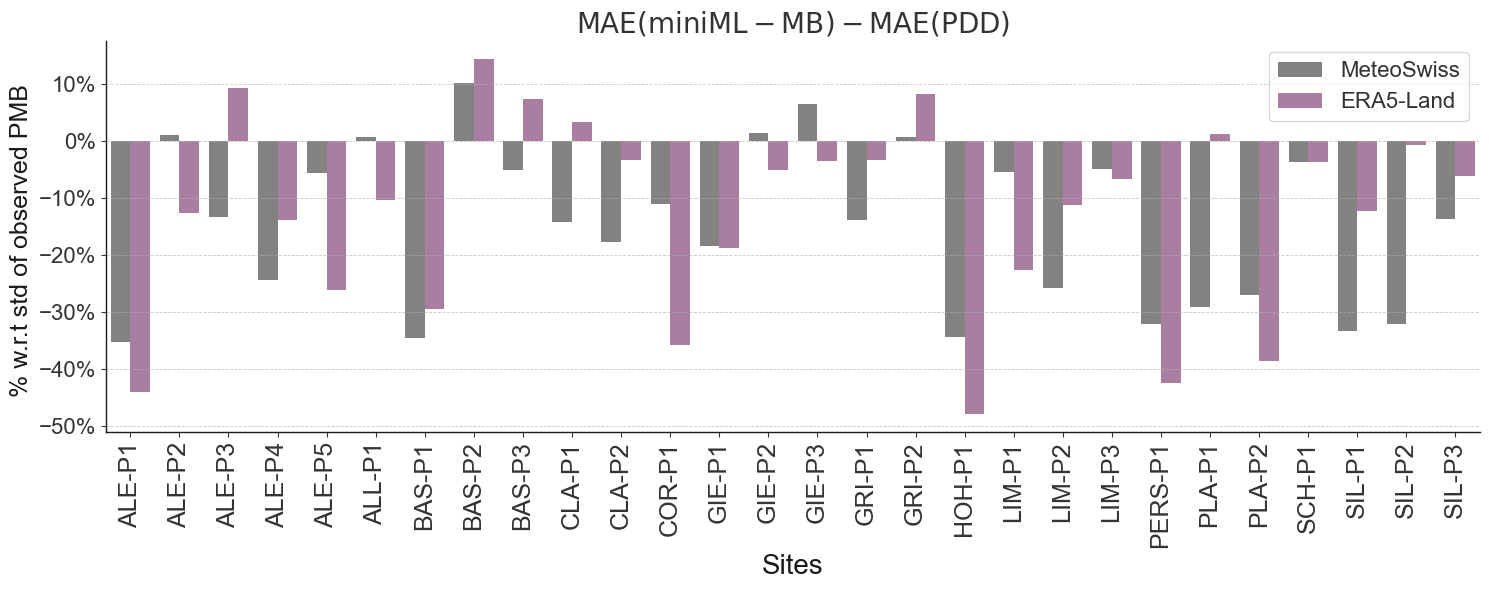

In [15]:
df_diff_best_MS = calcDiff(df_metrics_best_MS, df_metrics_pdd_MS)
df_diff_best_era5 = calcDiff(df_metrics_best_era5, df_metrics_pdd)

df_diff_best_era5['input_type'] = 'ERA5-Land'
df_diff_best_MS['input_type'] = 'MeteoSwiss'
df_diff = pd.concat([df_diff_best_MS,df_diff_best_era5,], axis = 0).sort_values(by = 'stakes_full')

palette_extremes = sns.color_palette([color_diff_xgbplus, '#8f3d7f'])

fig = plt.figure(figsize=(15,6))
M, N = 1, 1

# Diff MAE:
ax1 = plt.subplot(
    M,
    N,
    1,
)
g = sns.barplot(
    df_diff,
    x='stakes_full',
    y = 'diff_mae_wrt_to_std',
    hue='input_type',
    ax=ax1,
    # dodge=False,
    alpha=0.7,
    # color=color_diff_xgbplus,
    palette=palette_extremes
)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
h, l = g.get_legend_handles_labels()
# ax1.legend(
#     h,
#     l,
#     bbox_to_anchor=(1.05, 1),
#     loc=2,
#     ncol=1,
#     borderaxespad=0.0,
# )
ax1.set_ylabel('% w.r.t std of observed PMB ', fontsize=18)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# ax1.legend([], [], frameon=False)
ax1.legend(loc = 'upper right', fontsize = 16)
ax1.set_xlabel('Sites', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=18)
ax1.set_title('$\mathrm{MAE(miniML-MB)-MAE(PDD)}$', fontsize=20)
plt.tight_layout()
plt.savefig("figures/fig_ERA5_Land.pdf",
            format="pdf",
            bbox_inches="tight")